# Python DAQ (Arduino Uno → Jupyter)
Live plot + CSV logging using **pyserial + matplotlib**.

**Workflow**
1. Upload Arduino sketch that streams `us,raw` lines over Serial.
2. Run notebook cells top-to-bottom.
3. When finished, run the **Stop + Export** cell to close the port and write the CSV.

> Tip: Close the Arduino Serial Monitor while running Python (the port is often exclusive).


## 0) Install / environment notes
If you’re using **Anaconda**, you can install the interactive matplotlib backend (recommended) once:

```bash
conda install -c conda-forge ipympl pyserial pandas matplotlib
```

Then restart the kernel.

If `%matplotlib widget` fails, try `%matplotlib notebook` (classic Notebook) or use the script-based approach.


In [1]:
# Interactive plotting backend (best for live updates in Jupyter)
%matplotlib widget

import time
import threading
from collections import deque

import serial
import serial.tools.list_ports

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## 1) List available serial ports
Unplug/replug the Arduino if you’re unsure which port is yours (the new port that appears is usually the Arduino).


In [19]:
ports = list(serial.tools.list_ports.comports())

if not ports:
    print("No serial ports found. Plug in the Arduino and try again.")
else:
    print("Available serial ports:")
    for p in ports:
        print(f"  {p.device}  —  {p.description}")

Available serial ports:
  /dev/cu.debug-console  —  n/a
  /dev/cu.Bluetooth-Incoming-Port  —  n/a
  /dev/cu.usbmodem1201  —  IOUSBHostDevice
  /dev/cu.usbmodem125479901  —  USB Serial


## 2) Connect to the Arduino
Edit `PORT` to match your Arduino port from the list above.

- macOS often looks like: `/dev/cu.usbmodemXXXX`
- Windows often looks like: `COM5`

Also check that `BAUD` matches the baud rate specified in `Serial.begin()` in your Arduino sketch


In [20]:
# --- EDIT THIS ---
PORT = "/dev/cu.usbmodem125479901"   # e.g., "COM5" on Windows
BAUD = 115200

# Connect (opening the port typically resets the Arduino)
ser = serial.Serial(PORT, BAUD, timeout=1)
time.sleep(2)

print(f"Connected to {PORT} at {BAUD} baud")

Connected to /dev/cu.usbmodem125479901 at 115200 baud


## 3) Quick sanity check (optional)
Read a few lines to confirm Python is receiving data.
You should see lines like: `1234567,512`


In [6]:
for _ in range(5):
    s = ser.readline().decode("utf-8", errors="ignore").strip()
    print(repr(s))

'99098000,907'
'99099000,907'
'99100000,907'
'99101000,906'
'99102000,907'


## 4) Start acquisition (background thread)
This cell starts a background reader thread that:
- reads serial lines (`us,raw`)
- fills plotting buffers (last *N* points)
- logs the full run into `log_rows` for CSV export

If your Arduino prints a header like `us,raw`, it will be ignored automatically.


In [21]:
# Plot buffers: keep the most recent N points
N = 500
tbuf = deque(maxlen=N)   # time (s)
vbuf = deque(maxlen=N)   # volts (V) computed from raw

# Log buffer: store the entire run for CSV export
log_rows = []

stop_flag = False
t0_pc = time.time()

def parse_line(line: str):
    '''
    Expected line format from Arduino:
        us,raw
        1234567,512
    Returns (arduino_us:int, raw:int) or None.
    '''
    s = line.strip()
    if not s:
        return None
    if s.lower().startswith("us"):  # header line like "us,raw"
        return None

    parts = s.split(",")
    if len(parts) != 2:
        return None

    try:
        arduino_us = int(parts[0].strip())
        raw = int(parts[1].strip())
        return arduino_us, raw
    except ValueError:
        return None

def reader():
    '''
    Background thread: drains the serial port continuously.
    Keep this loop lightweight to reduce the chance of falling behind.
    '''
    global stop_flag
    ser.reset_input_buffer()

    while not stop_flag:
        line = ser.readline().decode("utf-8", errors="ignore")
        parsed = parse_line(line)
        if parsed is None:
            continue

        arduino_us, raw = parsed

        # Convert for plotting (convert raw->volts in Python; adjust Vref if needed)
        t_s = arduino_us / 1_000_000.0
        volts = raw * (5.0 / 1023.0)

        # Plot buffers (rolling window)
        tbuf.append(t_s)
        vbuf.append(volts)

        # Full log (for CSV)
        log_rows.append({
            "pc_time_s": time.time() - t0_pc,
            "arduino_us": arduino_us,
            "raw": raw,
            "volts": volts
        })

thread = threading.Thread(target=reader, daemon=True)
thread.start()

print("Reader thread started.")

Reader thread started.


## 5) Live plot (Optional)
This uses `FuncAnimation` to update at ~20 FPS (interval = 50 ms).
The plot is *decoupled* from acquisition: plotting is a view of the rolling buffer.


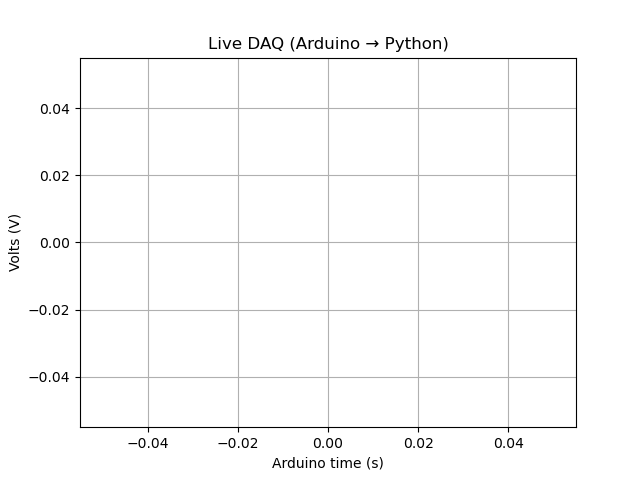

In [22]:
fig, ax = plt.subplots()
(line_plot,) = ax.plot([], [])
ax.set_xlabel("Arduino time (s)")
ax.set_ylabel("Volts (V)")
ax.grid(True)
ax.set_title("Live DAQ (Arduino → Python)")

def init():
    line_plot.set_data([], [])
    return (line_plot,)

def update(_frame):
    if len(tbuf) < 2:
        return (line_plot,)

    x = list(tbuf)
    y = list(vbuf)

    line_plot.set_data(x, y)
    ax.relim()
    ax.autoscale_view()
    return (line_plot,)

ani = FuncAnimation(
    fig,
    update,
    init_func=init,
    interval=50,
    blit=False,
    cache_frame_data=False
)

plt.show()

## 6) Stop + export to CSV ✅
Run this when you’re done collecting data.

This cell:
- stops acquisition thread
- stops animation
- closes the serial port
- closes the figure (important for Jupyter)
- writes the full log to CSV


In [23]:
# 1) Stop acquisition
stop_flag = True
thread.join(timeout=1)

# 2) Stop animation (prevents the kernel from staying "busy")
try:
    ani.event_source.stop()
except Exception:
    pass

# 3) Close serial
try:
    ser.close()
except Exception:
    pass

# 4) Close figure
plt.close(fig)

# 5) Export CSV
df = pd.DataFrame(log_rows)

timestamp = time.strftime("%Y%m%d_%H%M%S")
csv_name = f"daq_data_{timestamp}.csv"

df.to_csv(csv_name, index=False)
print(f"Saved {len(df)} samples to {csv_name}")

df.head()

Saved 158257 samples to daq_data_20260115_134008.csv


,pc_time_s,arduino_us,raw,volts
0,0.003902,26525600,933,4.560117
1,0.004820,26525800,933,4.560117
2,0.004876,26526000,933,4.560117
3,0.005441,26526200,933,4.560117
4,0.006506,26526400,933,4.560117


## 7) (Optional) Quick post-run plot
This is a static plot of the full run (after Stop + Export).


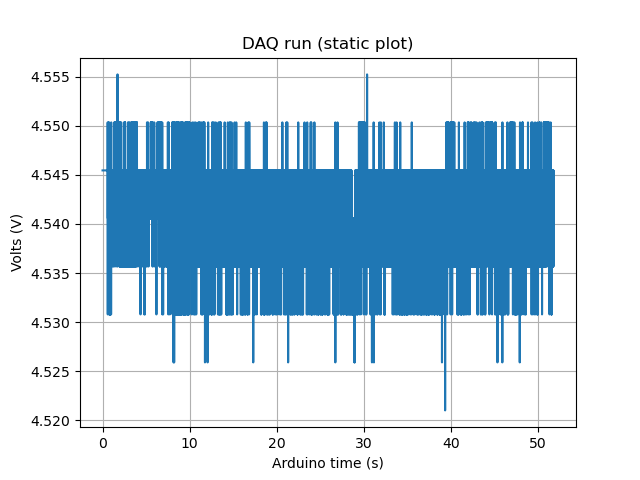

In [13]:
if "df" in globals() and len(df) > 0:
    plt.figure()
    plt.plot(df["arduino_us"] / 1_000_000.0, df["volts"])
    plt.xlabel("Arduino time (s)")
    plt.ylabel("Volts (V)")
    plt.title("DAQ run (static plot)")
    plt.grid(True)
    plt.show()
else:
    print("No data captured (or df not created yet). Run Stop + Export first.")